In [8]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

In [9]:
# zigzag edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])



def make_system(W=200, L=200, mu=0.6, phi=0):

            
    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction # does not work with vortex
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        return -t*exp(-1j * pi* phi * (xi - xj) * (yi + yj))
    
    def onsite(site, mu):
        return  - mu

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    graphene = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                     [(0, 0), (0, 1 / sqrt(3))],norbs=1)
    subA, subB = graphene.sublattices
    syst = kwant.Builder()
    syst[(subA(0,y) for y in range(L+1))] = onsite
    syst[(subB(0,y) for y in range(-1,L))] = onsite
    syst[graphene.neighbors()] = hopping_ab


    sym_left = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    left_lead = kwant.Builder(sym_left)
# #     left_lead[lat.shape(lead_slab, (0,0))] = onsite
#     L_lead=int(W/(sqrt(3)/2))
    left_lead[(subA(0,y) for y in range(L+1))] = onsite
    left_lead[(subB(0,y) for y in range(-1,L))] = onsite
    left_lead[graphene.neighbors()] = hopping_ab
    syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

#     a0=3/(4*sqrt(3))
#     b0=0.5
#     primitive_vectors = [(b0, 0), (0, a0)]
#     lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(0, a0/6),norbs=4)
    
            
#     # leads
#     def onsite_lead(site, mu_lead):
#         return  (- mu_lead + 4 * t)* np.kron(tau_z,np.eye(2))

#     def hopping_lead(site1, site2):
#         return -t*np.kron(tau_z,np.eye(2))

#     # Manually attach sites from graphene to square lattice
#     Wsys=int(W/a0)
#     Lsys=int(L/b0)
#     syst[(lat_sc(-1, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(-1, i), lat_sc(-1, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(-1, 2*i), subA(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(-1, 2*i+1), subB(-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[(lat_sc(Lsys, i) for i in range(Wsys))] = onsite_lead
#     syst[((lat_sc(Lsys, i), lat_sc(Lsys, i+1)) for i in range(Wsys-1))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i), subA(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead
#     syst[((lat_sc(Lsys, 2*i+1), subB(L-1-int(i/2), i)) for i in range(int(Wsys/2)))] = hopping_lead

#     claw=-np.kron(np.eye(2),tau_z)
#     sym_left = kwant.TranslationalSymmetry(lat_sc.vec((-1, 0)))
#     left_lead = kwant.Builder(sym_left, conservation_law=claw, particle_hole=np.kron(tau_x,np.eye(2)) )
#     left_lead[(lat_sc(0,y) for y in range(Wsys))] = onsite_lead
#     left_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_ab
#     left_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_ab
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

    
    return syst

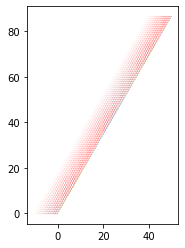

In [10]:
# Wsc must be multiples of eight
W=10
L=100
syst = make_system(W=W, L=L)
# Check that the system looks as intended.
# kwant.plot(syst, colorbar=False,fig_size=(40,80))
kwant.plot(syst,num_lead_cells=10)
# Finalize the system.
syst = syst.finalized()

In [11]:
mu=0.0
phi=0.05
momenta = [-pi + 0.02 * pi * i for i in range(101)]
def plot_wf(phi=0):
    params=dict(mu=mu, phi=phi, momenta=momenta)
    fig = plt.figure()  # create a figure object
    ax1 = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    kwant.plotter.bands(syst.leads[0],params=params,ax=ax1)
    ax1.set_ylim(-2,2)
    plt.show()
    
interact(plot_wf, phi=(0, 0.1, 0.002));

interactive(children=(FloatSlider(value=0.0, description='phi', max=0.1, step=0.002), Output()), _dom_classes=…

In [12]:
# armchair edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0, V_j=0,
                W=200, L=200, Lsc=20, L_lead=20, t_j=0.1, m=0, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (Lsc/2 <= abs(y) < L+Lsc/2)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj))),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj)))]])
        H1=np.kron(H1s,np.eye(2))
        return H1

    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsiteA(site, m, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)+m- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)


    def onsiteB(site, m, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)-m- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 1/2),(5/sqrt(3)/2, 1/2)],norbs=4)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
#     syst[lat.shape(qh_slab, (0,int(Lsc/2)))] = onsite
#     syst[lat.shape(qh_slab, (0,-int(Lsc/2)))] = onsite
    syst[subA1.shape(qh_slab, (0,int(Lsc/2)))] = onsiteA
    syst[subA2.shape(qh_slab, (3/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteA
    syst[subB1.shape(qh_slab, (1/sqrt(3),int(Lsc/2)))] = onsiteB
    syst[subB2.shape(qh_slab, (5/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteB
    
    syst[subA1.shape(qh_slab, (0,-int(Lsc/2)))] = onsiteA
    syst[subA2.shape(qh_slab, (3/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteA
    syst[subB1.shape(qh_slab, (1/sqrt(3),-int(Lsc/2)))] = onsiteB
    syst[subB2.shape(qh_slab, (5/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteB

    syst[lat.neighbors()] = hopping_ab

    def hopping_jn(site_i, site_j, t_j):
        return -t_j*np.kron(tau_z,np.eye(2))

    # sc part
    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)


    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2
    
    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(a0, 0), (0, b0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/6,b0/2),norbs=4)

    Wsq=int(W/a0)
    Lsq=int(Lsc/b0)-1
    syst[(lat_sc(x,y) for x in range(Wsq) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc
    syst[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    syst[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    syst[((lat_sc(4*i,int(Lsq/2)-1), subA1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,int(Lsq/2)-1), subB1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,int(Lsq/2)-1), subA2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,int(Lsq/2)-1), subB2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i,-int(Lsq/2)), subA1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,-int(Lsq/2)), subB1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,-int(Lsq/2)), subA2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,-int(Lsq/2)), subB2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn


    def onsite_lead(site, mu, gn):
        return  - mu* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsite_sc_lead(site, mu_sc, gs, Delta):
        return  (- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    
    sym_right = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    right_lead = kwant.Builder(sym_right, particle_hole=np.kron(tau_x,np.eye(2)))
#     right_lead[lat.shape(qh_slab, (0,int(Lsc/2)))] = onsite_lead
#     right_lead[lat.shape(qh_slab, (0,-int(Lsc/2)))] = onsite_lead
    right_lead[subA1.shape(qh_slab, (0,int(Lsc/2)))] = onsiteA
    right_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteA
    right_lead[subB1.shape(qh_slab, (1/sqrt(3),int(Lsc/2)))] = onsiteB
    right_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteB
    
    right_lead[subA1.shape(qh_slab, (0,-int(Lsc/2)))] = onsiteA
    right_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteA
    right_lead[subB1.shape(qh_slab, (1/sqrt(3),-int(Lsc/2)))] = onsiteB
    right_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteB
    right_lead[lat.neighbors()] = hopping_ab
    
    right_lead[(lat_sc(x,y) for x in range(4) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc_lead
    right_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    right_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    
    right_lead[(lat_sc(0,int(Lsq/2)-1), subA1(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(1,int(Lsq/2)-1), subB1(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(2,int(Lsq/2)-1), subA2(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(3,int(Lsq/2)-1), subB2(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(0,-int(Lsq/2)), subA1(0,-int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(1,-int(Lsq/2)), subB1(0,-int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(2,-int(Lsq/2)), subA2(0,-int(Lsc/2)-1))] = hopping_jn
    right_lead[(lat_sc(3,-int(Lsq/2)), subB2(0,-int(Lsc/2)-1))] = hopping_jn

#     def onsite_jn(site, mu, V_j):
#         return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)+V_j- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

#     right_lead[subA1(0,int(Lsc/2))] = onsite_jn
#     right_lead[subB1(0,int(Lsc/2))] = onsite_jn
#     right_lead[subA2(0,int(Lsc/2))] = onsite_jn
#     right_lead[subB2(0,int(Lsc/2))] = onsite_jn
#     right_lead[subA1(0,-int(Lsc/2))] = onsite_jn
#     right_lead[subB1(0,-int(Lsc/2))] = onsite_jn
#     right_lead[subA2(0,-int(Lsc/2)-1)] = onsite_jn
#     right_lead[subB2(0,-int(Lsc/2)-1)] = onsite_jn


    def onsite_lead(site, mu_lead, gn):
        return  - mu_lead* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def hopping_lead(site_i, site_j):
        return -t*np.kron(tau_z,np.eye(2))


    c1 = np.diag([-2, -1, 1, 2])
#     sym_top = kwant.TranslationalSymmetry(lat.vec((0, 1)))
#     l1_lead = kwant.Builder(sym_top, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)))
#     l1_lead[(subA1(i,0) for i in range(int(W/3)))] = onsite_lead
#     l1_lead[(subB1(i,0) for i in range(int(W/3)))] = onsite_lead
#     l1_lead[(subA2(i,0) for i in range(int(W/3)))] = onsite_lead
#     l1_lead[(subB2(i,0) for i in range(int(W/3)))] = onsite_lead
#     l1_lead[lat.neighbors()] = hopping_lead


    def lead_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (L_lead <= abs(y) < L+Lsc/2)


    sym_left = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    l1_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)))
    l1_lead[lat.shape(lead_slab, (0,L_lead))] = onsite_lead
#     l1_lead[subA1.shape(qh_slab, (0,int(Lsc/2)))] = onsiteA
#     l1_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteA
#     l1_lead[subB1.shape(qh_slab, (1/sqrt(3),int(Lsc/2)))] = onsiteB
#     l1_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteB
    l1_lead[lat.neighbors()] = hopping_ab

    l2_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)))
    l2_lead[lat.shape(lead_slab, (0,-L_lead))] = onsite_lead
#     l2_lead[subA1.shape(qh_slab, (0,-int(Lsc/2)))] = onsiteA
#     l2_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteA
#     l2_lead[subB1.shape(qh_slab, (1/sqrt(3),-int(Lsc/2)))] = onsiteB
#     l2_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteB
    l2_lead[lat.neighbors()] = hopping_ab

#     syst.attach_lead(l1_lead)
    syst.attach_lead(l1_lead.reversed())
    syst.attach_lead(l2_lead.reversed())
    syst.attach_lead(right_lead)
    
    return syst

In [35]:
def make_system(Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0,
                W=200, L=200, Lsc=20, L_lead=20, t_j=0.1, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (Lsc/2 <= abs(y) < L+Lsc/2)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj))),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj)))]])
        H1=np.kron(H1s,np.eye(2))
        return H1

    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 1/2),(5/sqrt(3)/2, 1/2)],norbs=4)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
    syst[lat.shape(qh_slab, (0,int(Lsc/2)))] = onsite
    syst[lat.shape(qh_slab, (0,-int(Lsc/2)))] = onsite
    syst[lat.neighbors()] = hopping_ab

    def hopping_jn(site_i, site_j, t_j):
        return -t_j*np.kron(tau_z,np.eye(2))

    # sc part
    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2)) + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)


    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2
    
    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(a0, 0), (0, b0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/6,b0/2),norbs=4)

    Wsq=int(W/a0)
    Lsq=int(Lsc/b0)-1
    syst[(lat_sc(x,y) for x in range(Wsq) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc
    syst[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    syst[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    syst[((lat_sc(4*i,int(Lsq/2)-1), subA1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,int(Lsq/2)-1), subB1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,int(Lsq/2)-1), subA2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,int(Lsq/2)-1), subB2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i,-int(Lsq/2)), subA1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+1,-int(Lsq/2)), subB1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+2,-int(Lsq/2)), subA2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn
    syst[((lat_sc(4*i+3,-int(Lsq/2)), subB2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn


    def onsite_lead(site, mu, gn):
        return  - mu* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsite_sc_lead(site, mu_sc, gs, Delta):
        return  (- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    
    sym_right = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    right_lead = kwant.Builder(sym_right, particle_hole=np.kron(tau_x,np.eye(2)))
    right_lead[lat.shape(qh_slab, (0,int(Lsc/2)))] = onsite_lead
    right_lead[lat.shape(qh_slab, (0,-int(Lsc/2)))] = onsite_lead
    right_lead[lat.neighbors()] = hopping_ab
    
    right_lead[(lat_sc(x,y) for x in range(4) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc_lead
    right_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
    right_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    
    right_lead[(lat_sc(0,int(Lsq/2)-1), subA1(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(1,int(Lsq/2)-1), subB1(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(2,int(Lsq/2)-1), subA2(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(3,int(Lsq/2)-1), subB2(0,int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(0,-int(Lsq/2)), subA1(0,-int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(1,-int(Lsq/2)), subB1(0,-int(Lsc/2)))] = hopping_jn
    right_lead[(lat_sc(2,-int(Lsq/2)), subA2(0,-int(Lsc/2)-1))] = hopping_jn
    right_lead[(lat_sc(3,-int(Lsq/2)), subB2(0,-int(Lsc/2)-1))] = hopping_jn

    
    def lead_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (L_lead <= abs(y) < L+Lsc/2)
    
    c1 = np.diag([-2, -1, 1, 2])
    sym_left = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    l1_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)))
#     l1_lead[lat.shape(qh_slab, (0,int(Lsc/2)))] = onsite_lead
    l1_lead[lat.shape(lead_slab, (0,L_lead))] = onsite_lead
    l2_lead = kwant.Builder(sym_left, conservation_law=c1, particle_hole=np.kron(tau_x,np.eye(2)))
#     l2_lead[lat.shape(qh_slab, (0,-int(Lsc/2)))] = onsite_lead
    l2_lead[lat.shape(lead_slab, (0,-L_lead))] = onsite_lead
    l1_lead[lat.neighbors()] = hopping_ab
    l2_lead[lat.neighbors()] = hopping_ab


    syst.attach_lead(l1_lead.reversed())
    syst.attach_lead(l2_lead.reversed())
    syst.attach_lead(right_lead)
    
    return syst

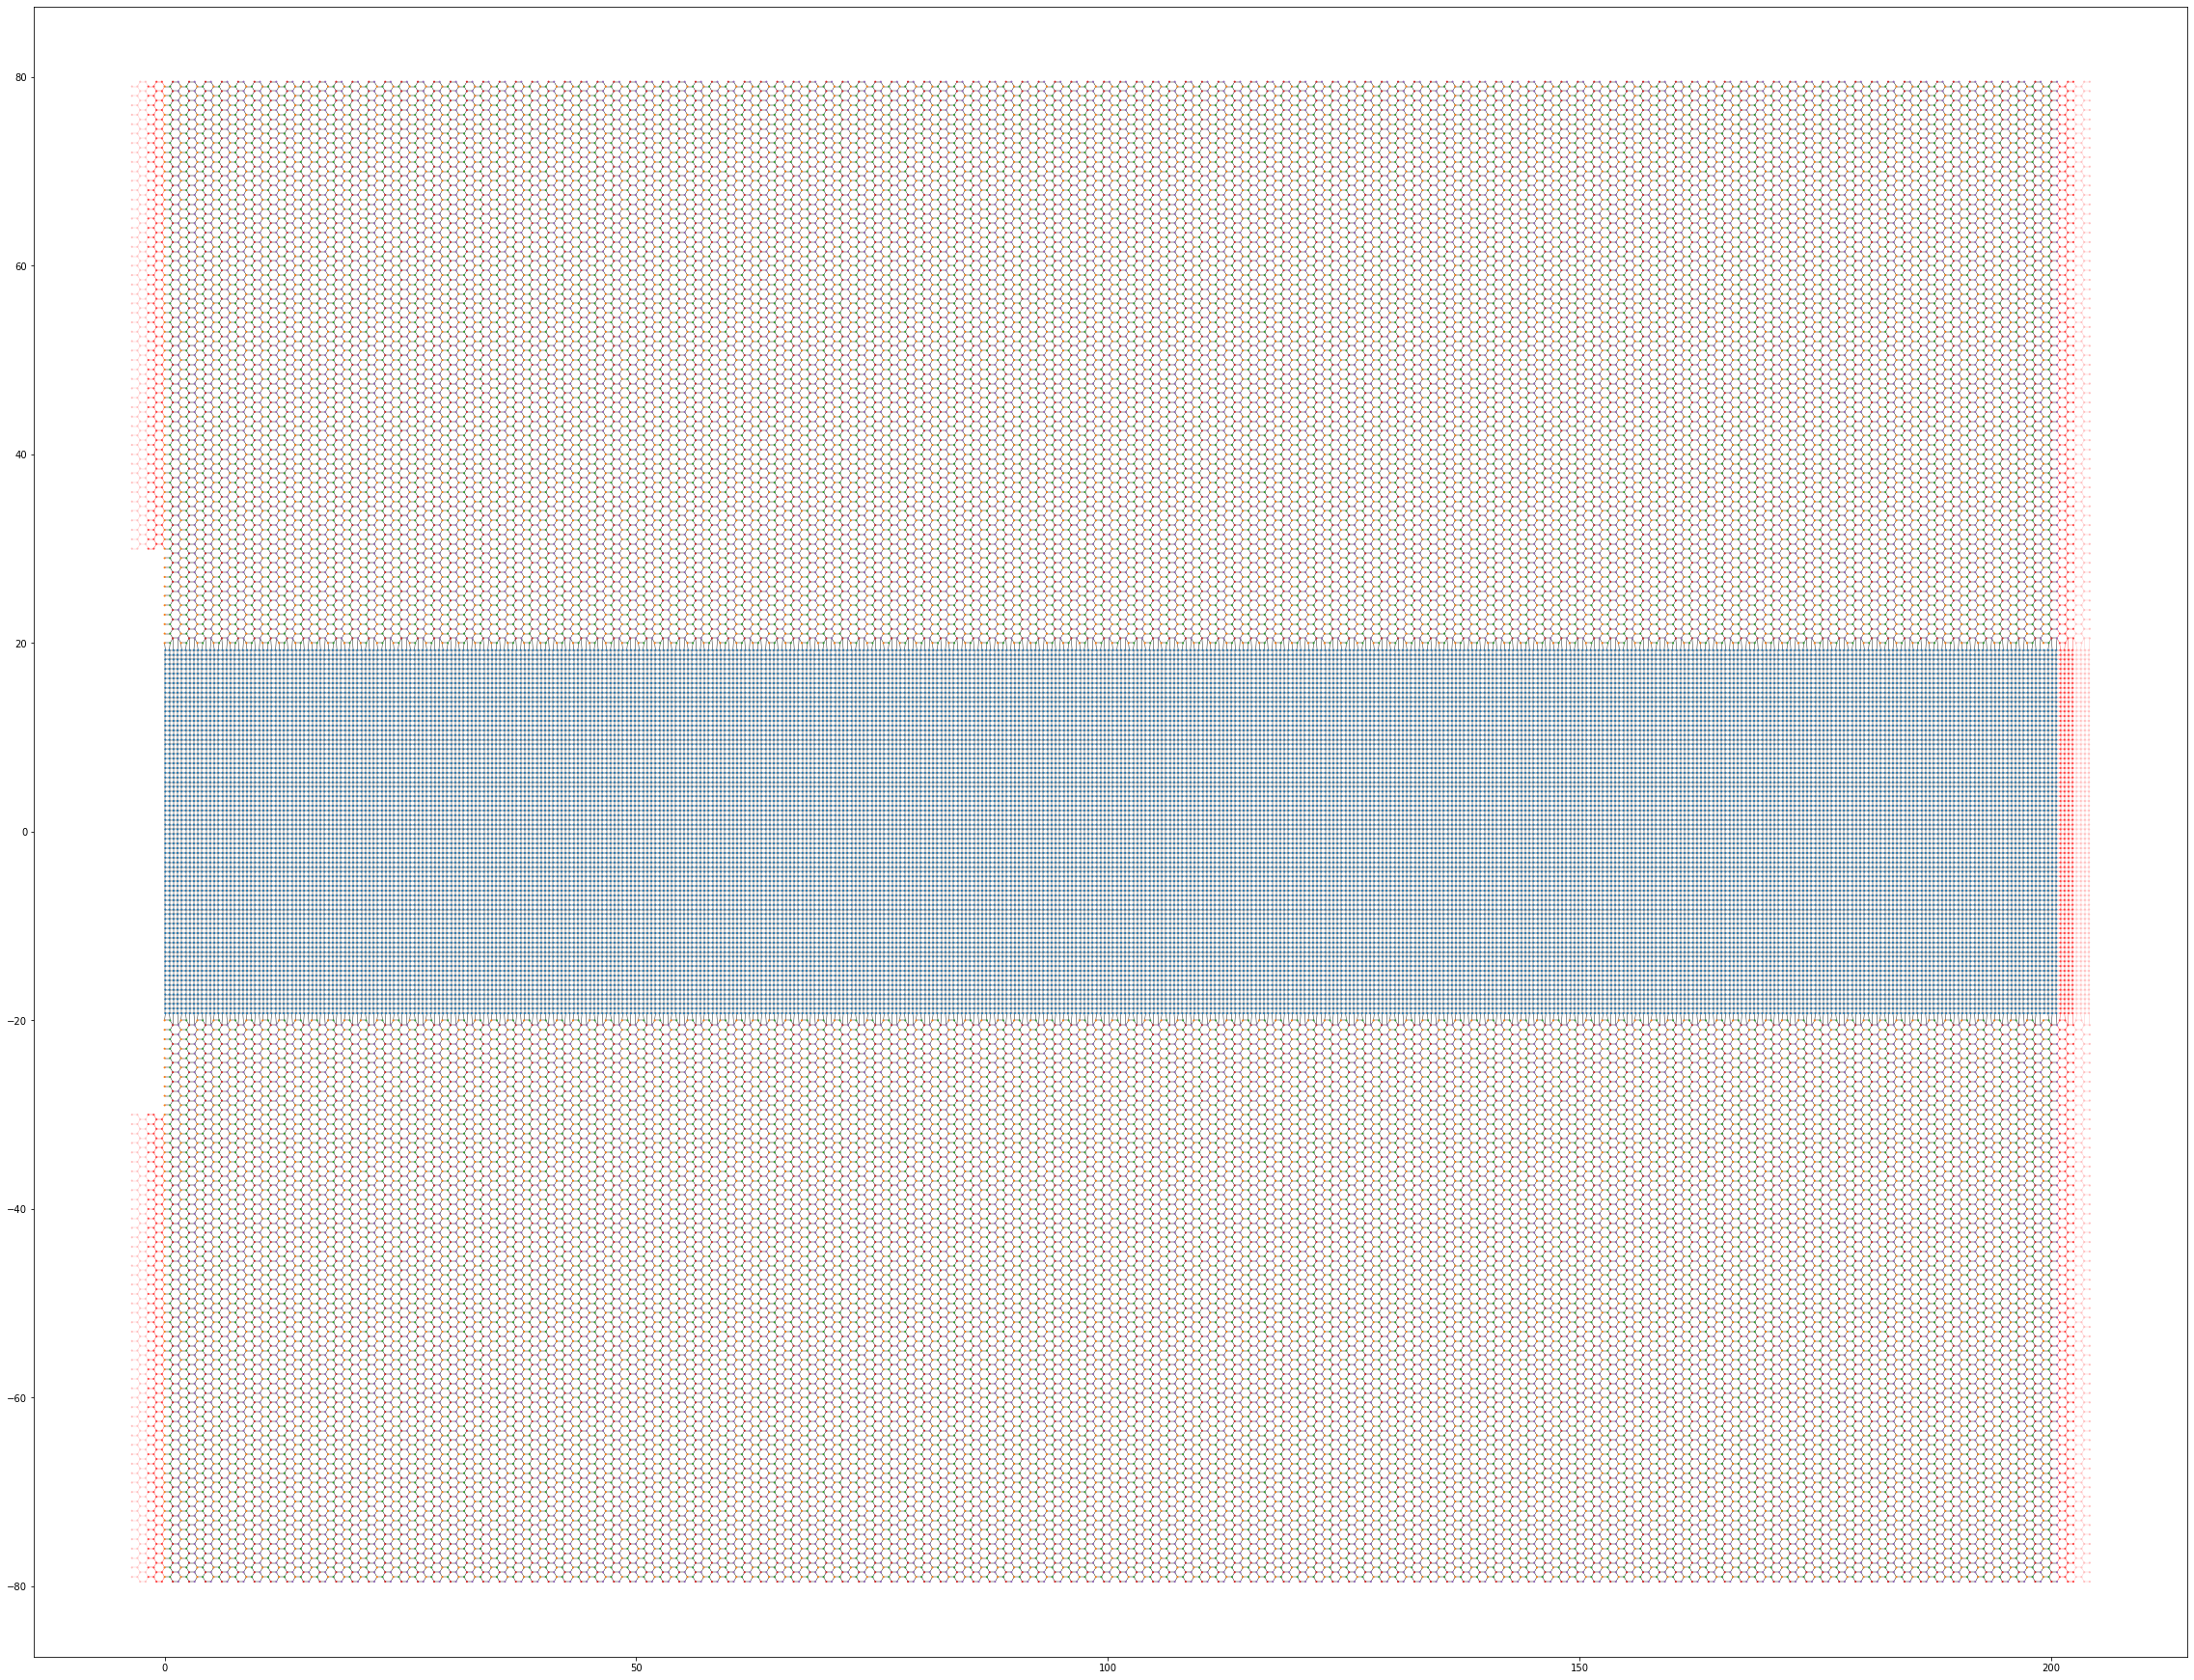

In [76]:
# Wsc must be multiples of eight
W = 200
L = 60
Lsc = 40
Llead = 30
syst = make_system(W=W, L=L, Lsc=Lsc, L_lead=Llead)
# Check that the system looks as intended.
kwant.plot(syst, colorbar=False,fig_size=(40,80),num_lead_cells=2)
# kwant.plot(syst,num_lead_cells=2)
# Finalize the system.
syst = syst.finalized()

(4, 367488)


<ipython-input-77-2a4699713842>:22: RuntimeWarning: The plotted data contains 1.70% of values overflowing upper limit 0.0284103 
  kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2,cmap='gist_heat_r')#,vmax=0.7);#,ax=ax1);


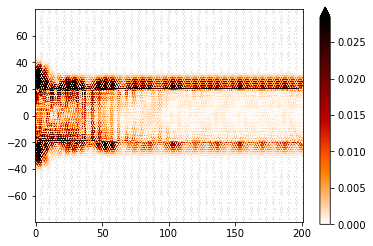

<ipython-input-77-2a4699713842>:23: RuntimeWarning: The plotted data contains 1.72% of values overflowing upper limit 0.0336896 
  kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);


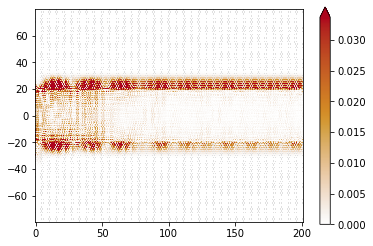

<ipython-input-77-2a4699713842>:24: RuntimeWarning: The plotted data contains 1.63% of values overflowing upper limit 0.0259148 
  kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2);#,ax=ax2);


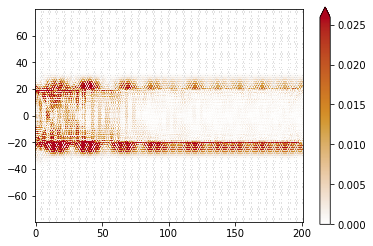

<ipython-input-77-2a4699713842>:25: RuntimeWarning: The plotted data contains 1.71% of values overflowing upper limit 0.0356874 
  kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax2);


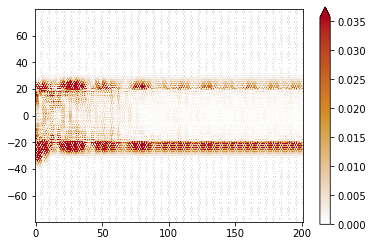

In [77]:
mu=0.18
m=0.
mu_sc= mu+t
mu_lead = 0.4
Delta=0.03
t_j=1.0
phi=0.0095
gs=0.
gn=0.04
lam=0.5
U0=0
salt=1
V_j=0.


energy=-0.*Delta
params=dict(t_j=t_j, gs=gs, gn=gn, lam=lam, V_j=V_j, Delta=Delta, U0=U0, salt=salt, m=m, mu=mu, mu_lead=mu_lead ,mu_sc=mu_sc, phi=phi)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
print(scattering_wf.shape)
ind=0
kwant.plotter.map(syst, abs(scattering_wf[ind,::4])**2,cmap='gist_heat_r')#,vmax=0.7);#,ax=ax1);
kwant.plotter.map(syst, abs(scattering_wf[ind,1::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2);#,ax=ax2);
kwant.plotter.map(syst, abs(scattering_wf[ind,3::4])**2);#,ax=ax2);

<ipython-input-78-b2fba758f858>:3: RuntimeWarning: The plotted data contains 1.47% of values overflowing upper limit 0.0177094 and 1.60% of values underflowing lower limit -0.0201932 
  ax = kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2- abs(scattering_wf[ind,::4])**2,cmap='RdBu');#,vmax=0.7);#,ax=ax1);


<Figure size 432x288 with 0 Axes>

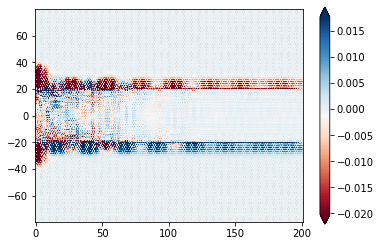

In [78]:

fig = plt.figure()
# ax = kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2- abs(scattering_wf[ind,::4])**2,cmap='RdBu');#,vmax=0.7);#,ax=ax1);
ax = kwant.plotter.map(syst, abs(scattering_wf[ind,2::4])**2- abs(scattering_wf[ind,::4])**2,cmap='RdBu');#,vmax=0.7);#,ax=ax1);
ax.savefig("figs/wf_presentation_thick.pdf")
# Zmat= abs(scattering_wf[ind,::4])**2-abs(scattering_wf[ind,2::4])**2
# Lx = W
# Ly = 2*(L + Lsc )
# Zmat_plot=np.fliplr(np.reshape(Zmat,[Lx,Ly])).T

# pos=plt.imshow(Zmat_plot, cmap='RdBu_r')#, aspect="auto",
# #                                 interpolation='none')
# plt.clim(-0.5,0.5)
# #     pyplot.clim(-0.11,0.11)
# plt.xlabel("x")
# plt.ylabel("y")


In [79]:
mu=0.18 #0.18
m= 0.0
lam=0.5
mu_sc= 0.18 +t -0*2*lam
mu_lead = 1
Delta=0.03
t_j=1
phi=0.0095
gs=0.
gn=0.04
U0=0
salt=1
V_j=0.

params=dict(t_j=t_j, gs=gs, gn=gn, lam=lam, V_j=V_j, Delta=Delta, U0=U0, salt=salt, m=m, mu=mu, mu_lead=mu_lead ,mu_sc=mu_sc, phi=phi)
def compute_conductance(syst, energies, params):
    # Compute conductance
    Pu = np.zeros((4,len(energies)))
    Pd = np.zeros((4,len(energies)))
    for i_e in range(len(energies)):
        print(i_e, end='\r')
        energy=energies[i_e]
        smatrix = kwant.smatrix(syst, energy=energy,params=params)
        for i in range(4):
            Pu[i,i_e]=smatrix.transmission((1, i), (0, 0))
            Pd[i,i_e]=smatrix.transmission((1, i), (0, 1))

    return Pu, Pd


# Compute and plot the conductance
E_list = np.array([0])
# E_list=np.arange(-20, 21)*0.05*Delta/4
# E_list=np.linspace(-1, 1, 20)*Delta*0.25
t_timer=time.time()
# Compute and plot the conductance
# Pe, Ph, wf_arr= compute_conductance(syst, energies=[E for E in E_list], params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt) )
Pu, Pd = compute_conductance(syst, energies=E_list, params=params )
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 57 sec


/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/kwant/solvers/common.py:820: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(self.block_offsets)[list(self.in_leads)]
/gscratch/home/hshapourian/miniconda3/lib/python3.8/site-packages/kwant/solvers/common.py:822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(self.block_offsets)[list(self.out_leads)]


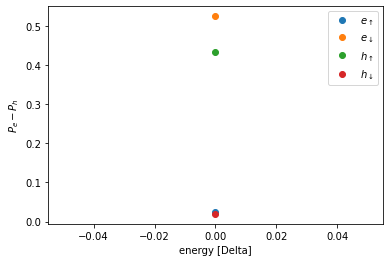

In [80]:
plt.figure()
plt.plot(E_list/Delta, Pd.T,'o')
plt.legend((r'$e_\uparrow$', r'$e_\downarrow$', r'$h_\uparrow$', r'$h_\downarrow$'))
plt.xlabel("energy [Delta]")
plt.ylabel(r"$P_e - P_h$")
# plt.ylim(-0.01,0.01)
P_diff_u=Pu[0,:]+Pu[1,:]-Pu[2,:]-Pu[3,:]
P_diff_d=Pd[0,:]+Pd[1,:]-Pd[2,:]-Pd[3,:]
# plt.plot(E_list/Delta, (P_diff_u+P_diff_d).T)
# plt.plot(RE_list/Delta, P_diff_d.T)
# print(np.max(P_diff_u+P_diff_d))
plt.show()

In [107]:
m= 0.0
lam=0.5
mu_sc= 0.18 +t -0*2*lam
mu_lead = 0.4
Delta=0.03
t_j=1
phi=0.0095
gs=0.
gn=0.04
U0=0
salt=1
V_j=0.

params=dict(t_j=t_j, gs=gs, gn=gn, lam=lam, V_j=V_j, Delta=Delta, U0=U0, salt=salt, m=m, mu_lead=mu_lead ,mu_sc=mu_sc, phi=phi)
def compute_conductance(syst, mu_list, params):
    energy=0
    # Compute conductance
    Pu = np.zeros((4,len(mu_list)))
    Pd = np.zeros((4,len(mu_list)))
    for i_m in range(len(mu_list)):
        print(i_m, end='\r')
        params['mu']=mu_list[i_m]
        smatrix = kwant.smatrix(syst, energy=energy,params=params)
        for i in range(4):
            Pu[i,i_m]=smatrix.transmission((1, i), (0, 0))
            Pd[i,i_m]=smatrix.transmission((1, i), (0, 1))

    return Pu, Pd


# Compute and plot the conductance
# E_list=np.arange(-20, 21)*0.05*Delta/4
mu_list=np.linspace(0, 0.4, 20)
mu_list=[mu_list[18]]
t_timer=time.time()
# Compute and plot the conductance
# Pe, Ph, wf_arr= compute_conductance(syst, energies=[E for E in E_list], params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt) )
Pu, Pd = compute_conductance(syst, mu_list, params=params )
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 5 sec


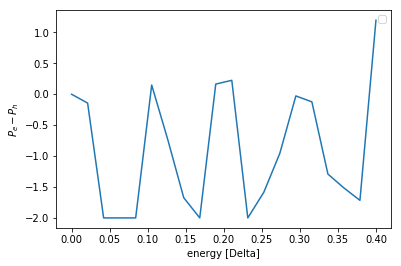

In [84]:
plt.figure()
# plt.plot(mu_list, Pu.T)
plt.legend((r'$e_\uparrow$', r'$e_\downarrow$', r'$h_\uparrow$', r'$h_\downarrow$'))
plt.xlabel("energy [Delta]")
plt.ylabel(r"$P_e - P_h$")
# plt.ylim(-0.01,0.01)
P_diff_u=Pu[0,:]+Pu[1,:]-Pu[2,:]-Pu[3,:]
P_diff_d=Pd[0,:]+Pd[1,:]-Pd[2,:]-Pd[3,:]
plt.plot(mu_list, (P_diff_u+P_diff_d).T)
# plt.plot(mu_list, P_diff_d.T)
plt.show()

In [145]:
mu=0.28 #0.18
m= 0.0
lam=0.
mu_sc= 0.18 +t -2*lam
mu_lead = 0.18
Delta=0.03
t_j=1
phi=0.0095
gs=0.
gn=0.04
U0=0
salt=1
V_j=0.

# momenta = [(-pi + 0.01 * pi * i)/5 for i in range(201)]
momenta=np.linspace(-1,1,200)*pi/4
params=dict(t_j=t_j, gs=gs, gn=gn, lam=lam,V_j=V_j, Delta=Delta, U0=U0, salt=salt, m=m, mu=mu ,mu_sc=mu_sc, phi=phi)
bands = kwant.physics.Bands(syst.leads[2], params=params)
energies = [bands(k) for k in momenta]

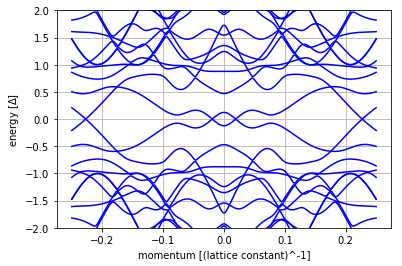

In [146]:
plt.figure()
plt.plot(np.array(momenta)/pi, np.array(energies)/Delta,'b')
# plt.plot((momenta), (energies))
plt.ylim(-2,2)
# plt.xlim(-1/sqrt(3),1/sqrt(3))
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel(r"energy [$\Delta$]")
plt.grid()
plt.show()